In [68]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ranksums, mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tabulate import tabulate

from ipynb.fs.full.preprocessing import preprocessing #import preprocessing class from preprocessing.ipynb

## Restore dataframes

In [69]:
#Restore saved class instances & dataframes from 00_EDA.ipynb
%store -r prep_dwt_8 prep_wang_8 prep_jones_8

%store -r dwt_8 wang_8 jones_8
dwt_8 = dwt_8
wang_8 = wang_8
jones_8 = jones_8

%store -r dwt_topten_8 wang_topten_8 jones_topten_8
dwt_topten_8 = dwt_topten_8
wang_topten_8 = wang_topten_8
jones_topten_8 = jones_topten_8

%store -r dwt_4 wang_4 jones_4
dwt_4 = dwt_4
wang_4 = wang_4
jones_4 = jones_4

%store -r dwt_topten_4 wang_topten_4 jones_topten_4
dwt_topten_4 = dwt_topten_4
wang_topten_4 = wang_topten_4
jones_topten_4 = jones_topten_4

## EDA

### Correlation Coefficient Matrix

In [70]:
cols = jones_8.columns
simplified_cols = [sub.replace('slope_', '') for sub in cols]

In [71]:
jones_8.columns = simplified_cols #rename columns to remove 'slope_' prefix

<Axes: >

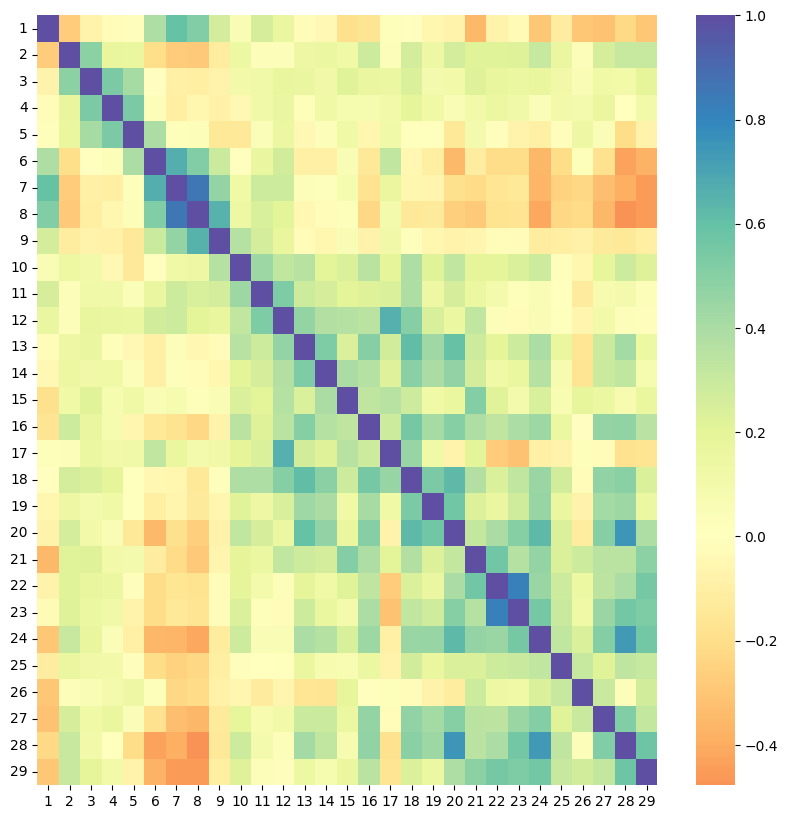

In [72]:
def corr_map(df=dwt_8, file_name='DWT 8-7-02'): #default fx runs dwt8 / DWT_8702

    df = df.loc[:, df.columns != 'state'] #remove state/supervisor column, df is features only
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 10))
    map = sns.heatmap(corr_matrix, annot=False, center=0, cmap="Spectral")#.set_title("Correlation Coefficient Matrix for " + file_name + " Method Slopes")
    plt.yticks(rotation='horizontal')
    
    return map

#display(corr_map(df=dwt_8, file_name='DWT 8-7-02')) #run fx with dwt
#display(corr_map(df=wang_8, file_name='Wang 8-7-02')) #run fx with wang
display(corr_map(df=jones_8, file_name='Jones 8-7-02')) #run fx with Jones

### Probability distribution of selected features

In [11]:
def plot_prdist(df, filtered_df, name):
    cols = list(filtered_df.columns)
    fig, axs = plt.subplots(5, 2, figsize=(15, 18))
    fig.suptitle("Probability Distribution of Top Ten Features by Fisher's Criterion for " + name)

    for i, ax in enumerate(axs.flat): #[:-1]
        sns.histplot(data=df, x=cols[i], hue='state', stat='probability', kde='True', ax=ax)
        list(dwt_filtered.columns)

    #fig.delaxes(axs[1,2]) #delete last subplot

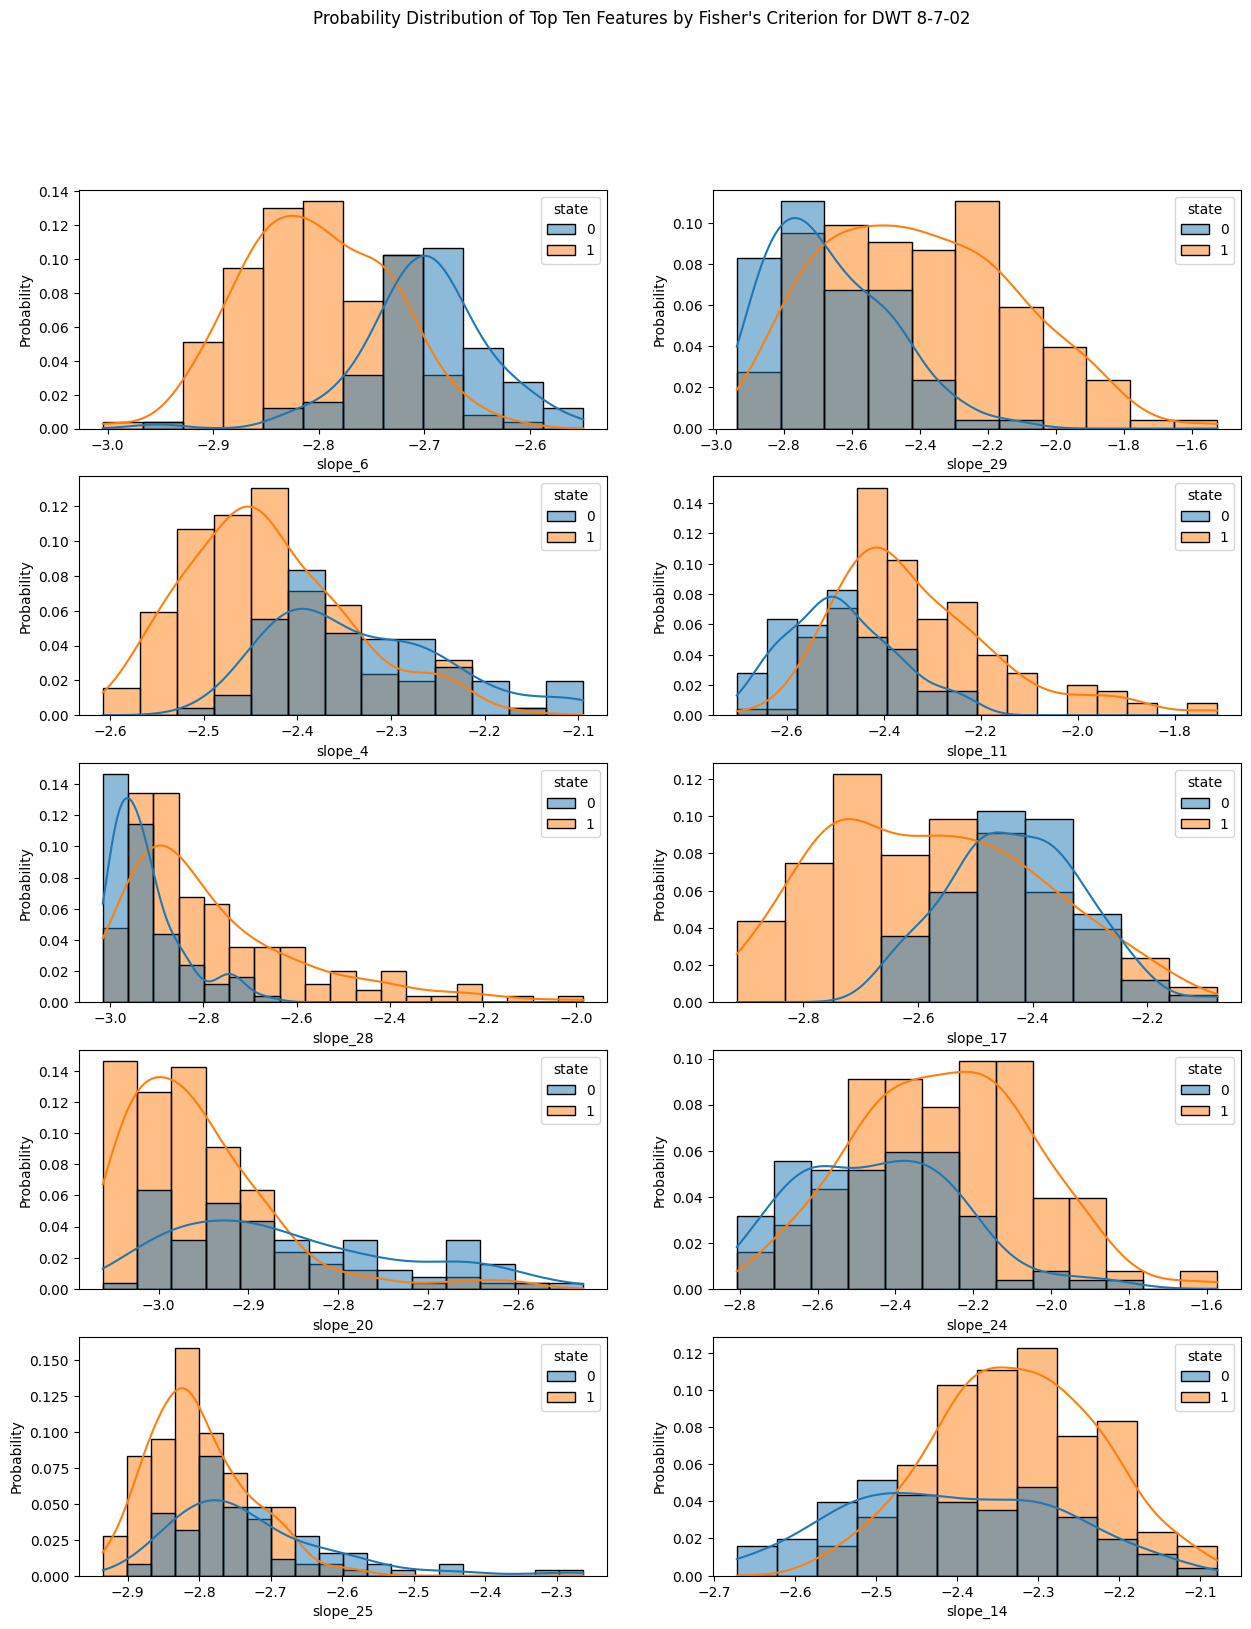

In [12]:
plot_prdist(dwt_8, dwt_topten_8, 'DWT 8-7-02')

### Wilcoxon Rank-Sum Test

Non-parametric version of the two-sample t-test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html

In [13]:
x = dwt_8['slope_6'][dwt_8['state'] == 0] #controls for slope_6 feature
y = dwt_8['slope_6'][dwt_8['state'] == 1] #cases for slope_6 feature

ranksums(x, y) 

RanksumsResult(statistic=9.930102403735122, pvalue=3.07939131215838e-23)

In [14]:
def wilcoxon_table(df, filtered_df, name):
    cols = list(filtered_df.columns)
    vals = []

    for i, col in enumerate(cols[:-1]):
        x = df[col][df['state'] == 0] #controls
        y = df[col][df['state'] == 1] #cases

        res = ranksums(x, y)

        vals.append([col, (res.pvalue)])

    print("Wilcoxon Rank-Sum Test for Top Five Features by Fisher's Criterion for " + name + " Method")
    print(tabulate(vals, headers=['Feature', 'p-value']))

In [15]:
wilcoxon_table(dwt_8, dwt_topten_8, 'DWT')

Wilcoxon Rank-Sum Test for Top Five Features by Fisher's Criterion for DWT Method
Feature        p-value
---------  -----------
slope_6    3.07939e-23
slope_29   5.38141e-14
slope_4    2.19463e-14
slope_11   6.6972e-14
slope_28   1.48518e-14
slope_17   3.97841e-10
slope_20   1.60339e-11
slope_24   1.81983e-08
slope_25   1.80104e-08
slope_14   3.24838e-06


In [16]:
wilcoxon_table(wang_8, wang_topten_8, 'Wang')

Wilcoxon Rank-Sum Test for Top Five Features by Fisher's Criterion for Wang Method
Feature        p-value
---------  -----------
slope_6    1.79317e-22
slope_27   1.03805e-18
slope_29   7.24662e-15
slope_17   1.02813e-12
slope_25   4.88905e-14
slope_21   4.32063e-14
slope_14   1.34993e-12
slope_4    1.35586e-13
slope_26   2.44636e-13
slope_19   3.85767e-12


In [17]:
wilcoxon_table(jones_8, jones_topten_8, 'Jones')

Wilcoxon Rank-Sum Test for Top Five Features by Fisher's Criterion for Jones Method
Feature        p-value
---------  -----------
slope_6    2.02079e-17
slope_28   1.00137e-16
slope_20   2.81717e-14
slope_5    3.84378e-13
slope_24   6.35053e-10
slope_23   3.66537e-09
slope_29   9.51077e-07
slope_22   6.83669e-06
slope_8    1.54883e-06
slope_16   1.13026e-06


## Scratchpad

### Variance Inflation Factors for Multicollinearity Detection

In [10]:
df_names = {'dwt': 'DWT 8-7-02', 
            'wang': 'Wang 8-7-02',
            'jones': 'Jones 8-7-02'
            } 

def vif(dfs = [dwt_8, wang_8, jones_8]): 

    for i, df in enumerate(dfs):
        
        df = df.loc[:, df.columns != 'state'] #remove state/supervisor column, df is features only
        
        vif_data = pd.DataFrame() #initialize dataframe for VIF values
        vif_data["feature_"+str(df_names[list(df_names.keys())[i]])] = df.columns #row for each feature
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

        print(vif_data)

vif() #demo with WPD_Wang_8702 file

   feature_DWT 8-7-02           VIF
0             slope_1   2336.750232
1             slope_2   2005.935714
2             slope_3   3420.935089
3             slope_4   1589.912227
4             slope_5   1378.838219
5             slope_6   2435.855732
6             slope_7   2234.657882
7             slope_8   4863.307851
8             slope_9   3219.558812
9            slope_10   3185.522650
10           slope_11    508.180275
11           slope_12    710.107008
12           slope_13   1307.667173
13           slope_14   3381.933984
14           slope_15   1212.642337
15           slope_16    399.576597
16           slope_17    454.546431
17           slope_18    989.285203
18           slope_19    938.973584
19           slope_20   2861.212647
20           slope_21   2901.686482
21           slope_22   3837.004678
22           slope_23   2565.473701
23           slope_24    361.996919
24           slope_25   1770.975915
25           slope_26  14531.729844
26           slope_27   9732